In [41]:
from langchain.chat_models import ChatOpenAI
from langchain.chains import create_extraction_chain
from langchain.document_loaders import AsyncChromiumLoader
from langchain.document_transformers import BeautifulSoupTransformer
from langchain.text_splitter import RecursiveCharacterTextSplitter

import pprint

## Sub-Domain Scanner

1. https://stackoverflow.com/questions/6925825/get-subdomain-from-url-using-python
2. https://www.geeksforgeeks.org/how-to-make-a-subdomain-scanner-in-python/


## Use Case

Web research is one of the killer LLM applications:
* Users have highlighted it as one of his top desired AI tools.
* OSS repos like gpt-researcher are growing in popularity.


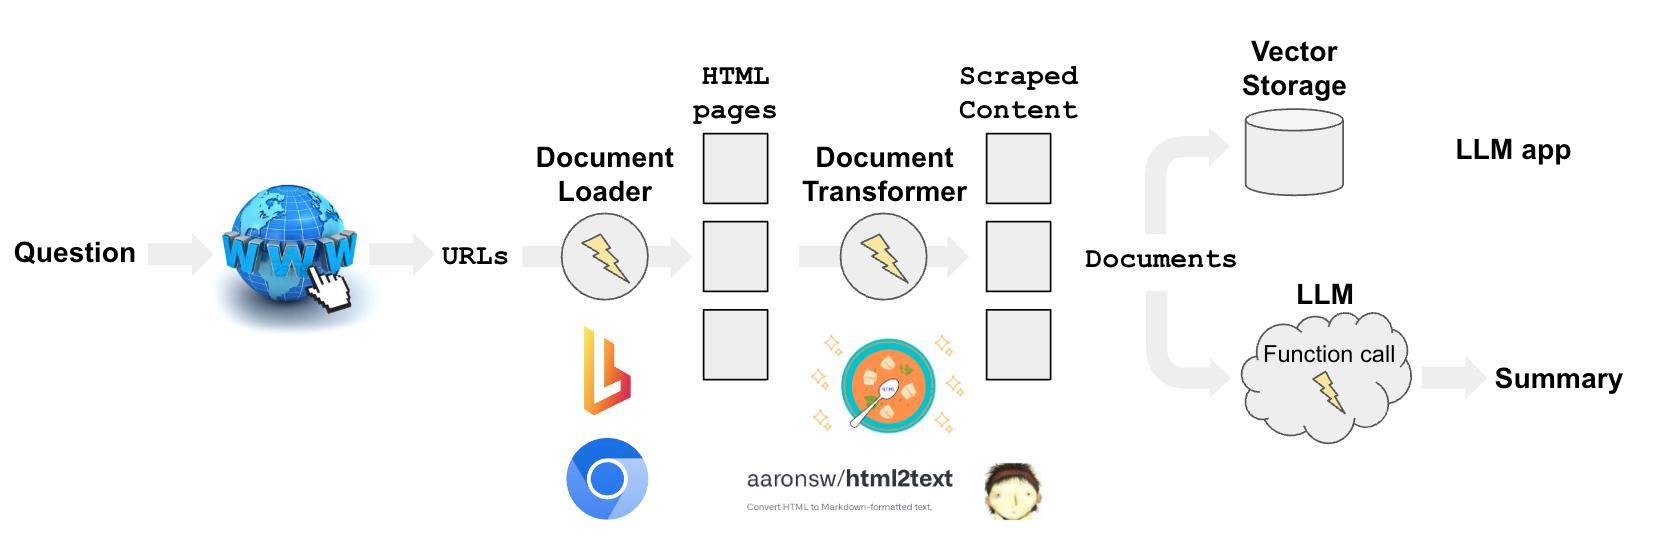

Gathering content from the web has a few components:

* `Search`: Query to url (e.g., using GoogleSearchAPIWrapper).
* `Loading`: Url to HTML (e.g., using AsyncHtmlLoader, AsyncChromiumLoader, etc).
* `Transforming`: HTML to formatted text (e.g., using HTML2Text or Beautiful Soup).

In [33]:
# Load HTML
loader = AsyncChromiumLoader(["https://www.wsj.com"])
html = loader.load()

Scrape text content tags such as \<p>, \<li>, \<div>, and \<a> tags from the HTML content:
* `<p>`: The paragraph tag. It defines a paragraph in HTML and is used to group together related sentences and/or phrases.

* `<li>`: The list item tag. It is used within ordered (`<ol>`) and unordered (`<ul>`) lists to define individual items within the list.

* `<div>`: The division tag. It is a block-level element used to group other inline or block-level elements.

* `<a>`: The anchor tag. It is used to define hyperlinks.

* `<span>`: an inline container used to mark up a part of a text, or a part of a document.

In [34]:
# Transform
bs_transformer = BeautifulSoupTransformer()
docs_transformed = bs_transformer.transform_documents(html,tags_to_extract=["span"])

In [ ]:
# Result
docs_transformed[0].page_content[0:500]

## Loader

* `AsyncHtmlLoader`: uses the _aiohttp_ library to make asynchronous HTTP requests, suitable for simpler and lightweight scraping.

* `AsyncChromiumLoader`: uses Playwright to launch a Chromium instance, which can handle JavaScript rendering and more complex web interactions.

## Transformer

* `HTML2Text`: provides a straightforward conversion of HTML content into plain text (with markdown-like formatting) without any specific tag manipulation. It's best suited for scenarios where the goal is to extract human-readable text without needing to manipulate specific HTML elements.

* `Beautiful Soup`: Beautiful Soup offers more fine-grained control over HTML content, enabling specific tag extraction, removal, and content cleaning. It's suited for cases where you want to extract specific information and clean up the HTML content according to your needs.

## Scraping with Extraction

Using Function (e.g., OpenAI) with an extraction chain, we avoid having to change your code constantly when websites change.


In [37]:
llm = ChatOpenAI(temperature=0, model="gpt-3.5-turbo-0613", openai_api_key=open("openai_api.txt").read())

In [39]:
## Defining a Schema

schema = {
    "properties": {
        "news_article_title": {"type": "string"},
        "news_article_summary": {"type": "string"},
    },
    "required": ["news_article_title", "news_article_summary"],
}

def extract(content: str, schema: dict):
    return create_extraction_chain(schema=schema, llm=llm).run(content)

In [ ]:
def scrape_with_playwright(urls, schema):

    loader = AsyncChromiumLoader(urls)
    docs = loader.load()
    bs_transformer = BeautifulSoupTransformer()
    docs_transformed = bs_transformer.transform_documents(docs,tags_to_extract=["span"])
    print("Extracting content with LLM")

    # Grab the first 1000 tokens of the site
    splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=1000,
                                                                    chunk_overlap=0)
    splits = splitter.split_documents(docs_transformed)

    # Process the first split
    extracted_content = extract(
        schema=schema, content=splits[0].page_content
    )
    pprint.pprint(extracted_content)
    return extracted_content

urls = ["https://www.wsj.com"]
extracted_content = scrape_with_playwright(urls, schema=schema)